<a href="https://colab.research.google.com/github/Chaitanyareddynv/Cnarredd_64061/blob/main/assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Downloading the data**



In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  42.9M      0  0:00:01  0:00:01 --:--:-- 42.9M


Preparing the data

In [2]:
import os, pathlib, shutil, random
from tensorflow import keras
b_size = 32
b_dir7= pathlib.Path("/content/aclImdb")
v_dir7 = b_dir7/ "val"
tr_dir7 = b_dir7 / "train"
for category in ("neg", "pos"):
    os.makedirs(v_dir7 / category, exist_ok=True )

    files = os.listdir(tr_dir7 / category)
    random.Random(1496).shuffle(files)
    num_val_samples = 10000
    v_files = files[-num_val_samples:]
    for fname in v_files:
        shutil.move(tr_dir7 / category / fname,
                    v_dir7 / category / fname)

tr_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=b_size
).take(100)  # Restrict training samples to 100

v_ds = keras.utils.text_dataset_from_directory(
    "/content/aclImdb/val", batch_size=b_size
)
te_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=b_size
)
te_only_tr_ds = tr_ds.map(lambda x, y: x)


Found 5000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Setting up datasets for numeric sequences

**Building A sequence model on one-hot encoded vector sequences**


In [3]:
from tensorflow.keras import layers

max_l = 150   # Cutoff reviews after 150 words
max_t = 10000 # Consider only the top 10,000 word
t_vectorization = layers.TextVectorization(
    max_tokens=max_t,
    output_mode="int",
    output_sequence_length=max_l,
)
t_vectorization.adapt(te_only_tr_ds)

int_tr_ds = tr_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4)
int_v_ds = v_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4)
int_te_ds = te_ds.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4)

In [4]:
import tensorflow as tf  # Model with embedding layer
input = keras.Input(shape=(None,), dtype="int64")
em = layers.Embedding(input_dim=max_t, output_dim=256, mask_zero=True)(input)
x = layers.Bidirectional(layers.LSTM(32))(em)
x = layers.Dropout(0.5)(x)
ou = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(input, ou)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  2,560,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │     73,984 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

Developing a fundamental sequencing concept initially

In [5]:
cb = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
hist= model.fit(int_tr_ds, validation_data=int_v_ds, epochs=15, callbacks=cb)
model = keras.models.load_model("one_hot_bidir_lstm.keras")


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - accuracy: 0.5290 - loss: 0.6911 - val_accuracy: 0.5727 - val_loss: 0.6686
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.6634 - loss: 0.6104 - val_accuracy: 0.7336 - val_loss: 0.5411
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.8035 - loss: 0.4484 - val_accuracy: 0.7669 - val_loss: 0.4858
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.8804 - loss: 0.3202 - val_accuracy: 0.7577 - val_loss: 0.5193
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9083 - loss: 0.2562 - val_accuracy: 0.7871 - val_loss: 0.4589
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9437 - loss: 0.1650 - val_accuracy: 0.7836 - val_loss: 0.5541
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.9569 - loss: 0.1229 - val_accuracy: 0.7923 - val_loss: 0.5405
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.9685 - loss: 0.0946 - val_

In [6]:
test_loss, test_acc = model.evaluate(int_te_ds)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Evaluate model on the validation dataset
val_loss, val_acc = model.evaluate(int_v_ds)
print(f"Validation Loss: {val_loss:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7870 - loss: 0.4627
Test Loss: 0.461
Test Accuracy: 0.786
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7854 - loss: 0.4606
Validation Loss: 0.459
Validation Accuracy: 0.787


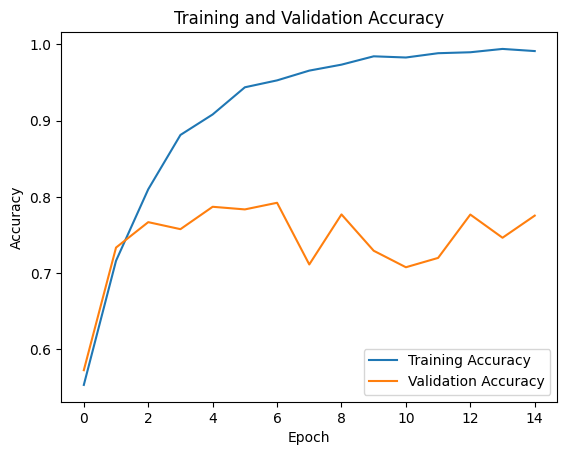

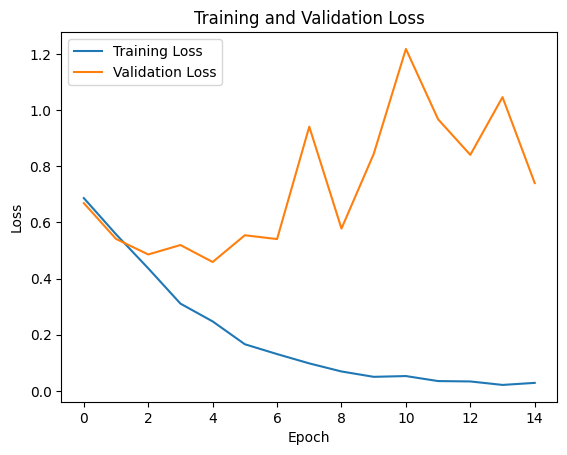

In [7]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Embedding the levels to acquire embedded words

Putting an Anchoring level into Action


In [8]:
em_layer = layers.Embedding(input_dim=max_t, output_dim=256)

Anchor layer system which was developed form start

In [9]:
in1 = keras.Input(shape=(None,), dtype="int64")
em1 = layers.Embedding(input_dim=max_t, output_dim=256)(in1)
x = layers.Bidirectional(layers.LSTM(32))(em1)
x = layers.Dropout(0.5)(x)
ou1 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in1, ou1)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, None, 256)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
cb1 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",
                                    save_best_only=True)
]
hist1= model.fit(int_tr_ds, validation_data=int_v_ds, epochs=15, callbacks=cb1)
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_te_ds)[1]:.3f}")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.5233 - loss: 0.6932 - val_accuracy: 0.6585 - val_loss: 0.6429
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.6793 - loss: 0.6212 - val_accuracy: 0.7556 - val_loss: 0.5189
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.7849 - loss: 0.4871 - val_accuracy: 0.7650 - val_loss: 0.4963
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.8416 - loss: 0.3875 - val_accuracy: 0.7592 - val_loss: 0.5415
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.8789 - loss: 0.3108 - val_accuracy: 0.7825 - val_loss: 0.5040
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8983 - loss: 0.2498 - val_accuracy: 0.7659 - val_loss: 0.5220
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9334 - loss: 0.2050 - val_accuracy: 0.7694 - val_loss: 0.5033
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9523 - loss: 0.1544 - val_

In [13]:
test_loss, test_acc = model.evaluate(int_te_ds)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Evaluate model on the validation dataset
val_loss, val_acc = model.evaluate(int_v_ds)
print(f"Validation Loss: {val_loss:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.5012 - loss: 0.6931
Test Loss: 0.693
Test Accuracy: 0.504
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5051 - loss: 0.6931
Validation Loss: 0.693
Validation Accuracy: 0.500


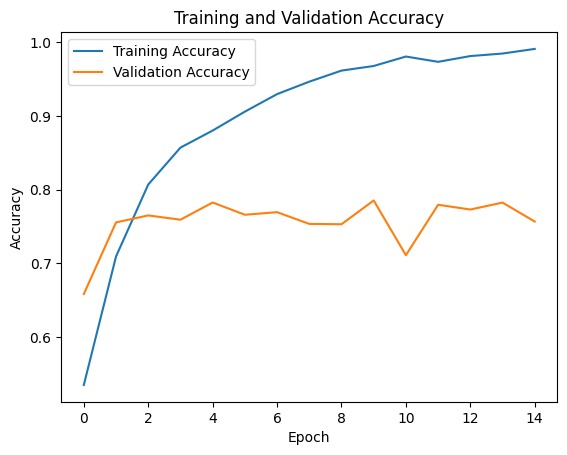

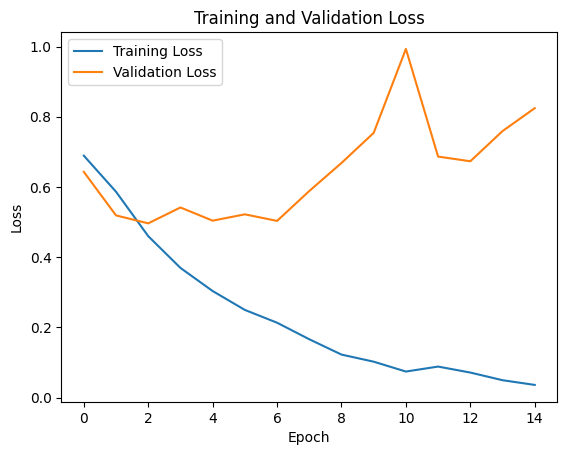

In [11]:
# Plot training and validation accuracy
plt.plot(hist1.history['accuracy'], label='Training Accuracy')
plt.plot(hist1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist1.history['loss'], label='Training Loss')
plt.plot(hist1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Recognizing blurring and filling

Applying filtering to an Anchoring level


In [12]:
in2 = keras.Input(shape=(None,), dtype="int64")
em2 = layers.Embedding(
    input_dim=max_t, output_dim=256, mask_zero=True)(in2)
x = layers.Bidirectional(layers.LSTM(32))(em2)
x = layers.Dropout(0.5)(x)
ou2 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in2, ou2)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 256) │  2,560,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 64)        │     73,984 │ embedding_3[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
cb2 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
hist2=model.fit(int_tr_ds, validation_data=int_v_ds, epochs=15, callbacks=cb2)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_te_ds)[1]:.3f}")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.5232 - loss: 0.6923 - val_accuracy: 0.5567 - val_loss: 0.6809
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.6442 - loss: 0.6381 - val_accuracy: 0.7267 - val_loss: 0.5456
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.7732 - loss: 0.4879 - val_accuracy: 0.7663 - val_loss: 0.4840
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.8514 - loss: 0.3588 - val_accuracy: 0.7305 - val_loss: 0.6217
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8858 - loss: 0.2949 - val_accuracy: 0.7974 - val_loss: 0.4859
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9172 - loss: 0.2130 - val_accuracy: 0.7416 - val_loss: 0.6406
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9343 - loss: 0.1775 - val_accuracy: 0.7959 - val_loss: 0.4759
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.9633 - loss: 0.1143 - val_ac

In [15]:
test_loss, test_acc = model.evaluate(int_te_ds)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Evaluate model on the validation dataset
val_loss, val_acc = model.evaluate(int_v_ds)
print(f"Validation Loss: {val_loss:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7878 - loss: 0.4864
Test Loss: 0.484
Test Accuracy: 0.788
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7925 - loss: 0.4807
Validation Loss: 0.476
Validation Accuracy: 0.796


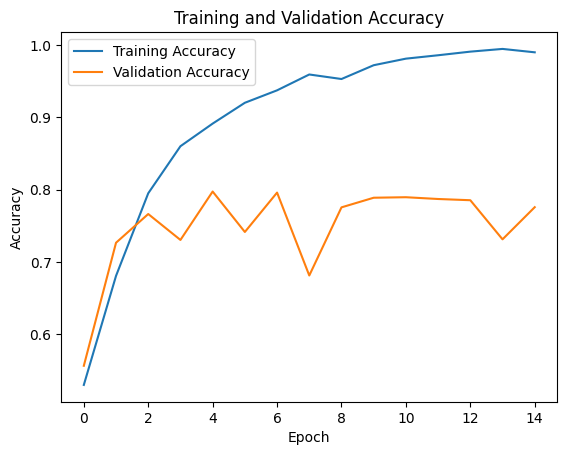

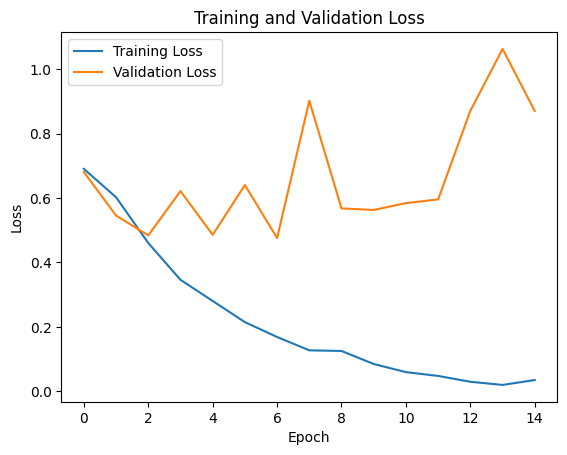

In [16]:
# Plot training and validation accuracy
plt.plot(hist2.history['accuracy'], label='Training Accuracy')
plt.plot(hist2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist2.history['loss'], label='Training Loss')
plt.plot(hist2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Preconditioned word embeds are used

In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-11-10 22:15:44--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-10 22:15:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-10 22:15:44--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Interpreting the word-embeddings package for One

In [18]:
import numpy as np
path_to_g_file = "glove.6B.100d.txt"

em_index = {}
with open(path_to_g_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        em_index[word] = coefs

print(f"Found {len(em_index)} word vectors.")

Found 400000 word vectors.


Setting up the matrix for the GloVe website embedded words

In [19]:
em_dim = 100

vocab = t_vectorization.get_vocabulary()
wo_index = dict(zip(vocab, range(len(vocab))))

em_matrix = np.zeros((max_t, em_dim))
for word, i in wo_index.items():
    if i < max_t:
        em_vector = em_index.get(word)
    if em_vector is not None:
        em_matrix[i] = em_vector

In [20]:
em_layer = layers.Embedding(
    max_t,
    em_dim,
    embeddings_initializer=keras.initializers.Constant(em_matrix),
    trainable=False,
    mask_zero=True,
)

# Architecture with an embedded level which has been trained

In [21]:
in4 = keras.Input(shape=(None,), dtype="int64")
em4 = em_layer(in4)
x = layers.Bidirectional(layers.LSTM(32))(em4)
x = layers.Dropout(0.5)(x)
ou4 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in4, ou4)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, None, 100) │  1,000,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, None)      │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 64)        │     34,048 │ embedding_4[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [22]:
cb4 = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]
hist4=model.fit(int_tr_ds, validation_data=int_v_ds, epochs=15, callbacks=cb4)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_te_ds)[1]:.3f}")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.5390 - loss: 0.6948 - val_accuracy: 0.6064 - val_loss: 0.6559
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.6325 - loss: 0.6454 - val_accuracy: 0.6635 - val_loss: 0.6138
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.6702 - loss: 0.6094 - val_accuracy: 0.7201 - val_loss: 0.5578
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.7137 - loss: 0.5680 - val_accuracy: 0.7365 - val_loss: 0.5348
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.7276 - loss: 0.5481 - val_accuracy: 0.7470 - val_loss: 0.5208
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.7562 - loss: 0.5158 - val_accuracy: 0.7529 - val_loss: 0.5044
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.7597 - loss: 0.4977 - val_accuracy: 0.7676 - val_loss: 0.4869
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.7796 - loss: 0.4731 - val_a

In [23]:
test_loss, test_acc = model.evaluate(int_te_ds)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

# Evaluate model on the validation dataset
val_loss, val_acc = model.evaluate(int_v_ds)
print(f"Validation Loss: {val_loss:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7801 - loss: 0.4584
Test Loss: 0.459
Test Accuracy: 0.779
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.7772 - loss: 0.4596
Validation Loss: 0.457
Validation Accuracy: 0.780


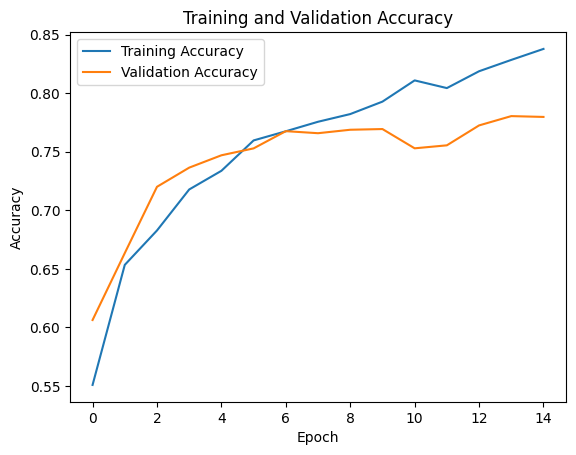

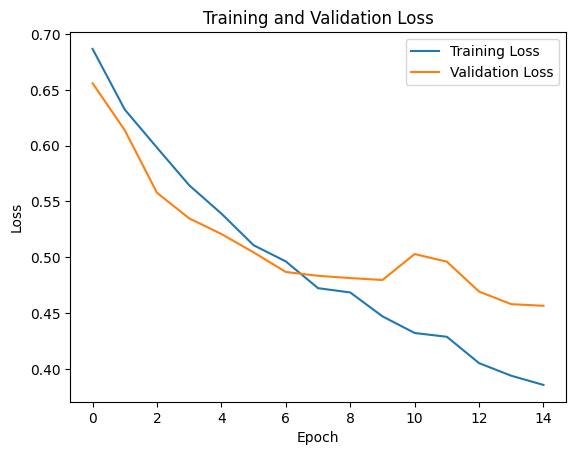

In [24]:
# Plot training and validation accuracy
plt.plot(hist4.history['accuracy'], label='Training Accuracy')
plt.plot(hist4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(hist4.history['loss'], label='Training Loss')
plt.plot(hist4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
train_sample_sizes = [100, 1000, 3000, 5000, 10000, 20000]
for train_size in train_sample_sizes:
    train_ds = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=b_size
    ).take(train_size)

    int_train_ds = train_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_val_ds = v_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_test_ds = te_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )


Found 5000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [27]:
 from tensorflow import keras
from tensorflow.keras import layers

# Define parameters (make sure these are set appropriately)
max_t = 10000   # Maximum number of tokens/vocabulary size
em_dim = 128    # Embedding dimension

# Define the embedding layer
embedding_layer = layers.Embedding(input_dim=max_t, output_dim=em_dim)

# Build the model
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer="rmsprop",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "embeddings_model.keras",
        save_best_only=True
    )
]

# Train the model
history = model.fit(
    int_train_ds,
    validation_data=int_val_ds,
    epochs=10,
    callbacks=callbacks
)

# Load the best model
model = keras.models.load_model("embeddings_model.keras")

# Evaluate on test set
test_loss, test_acc = model.evaluate(int_te_ds)
print(f"Test Loss: {test_loss:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.5242 - loss: 0.6896 - val_accuracy: 0.6230 - val_loss: 0.6560
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.7202 - loss: 0.5618 - val_accuracy: 0.7578 - val_loss: 0.5102
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.8176 - loss: 0.4458 - val_accuracy: 0.7901 - val_loss: 0.4546
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8654 - loss: 0.3468 - val_accuracy: 0.7917 - val_loss: 0.4650
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.9066 - loss: 0.2624 - val_accuracy: 0.7329 - val_loss: 0.6291
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9184 - loss: 0.2258 - val_accuracy: 0.7663 - val_loss: 0.5636
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.9351 - loss: 0.1846 - val_accuracy: 0.7926 - val_loss: 0.6630
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9489 - loss: 0.1443 - val_acc

625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7880 - loss: 0.4533
Validation Loss: 0.455
Validation Accuracy: 0.790
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7881 - loss: 0.4564


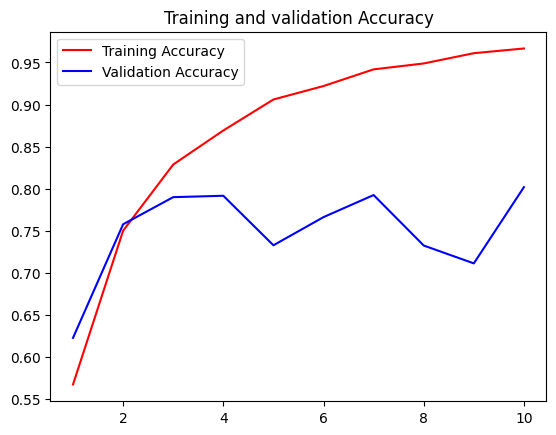

In [28]:
# Evaluate model on the validation dataset
val_loss, val_acc = model.evaluate(int_v_ds)
print(f"Validation Loss: {val_loss:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")


embedding_layer_test_acc = model.evaluate(int_test_ds)[1]

loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "r", label="Training Accuracy")
plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.show()


Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.5040 - loss: 0.6934 - val_accuracy: 0.6337 - val_loss: 0.6503
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.6626 - loss: 0.6317 - val_accuracy: 0.7232 - val_loss: 0.5619
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.7913 - loss: 0.4989 - val_accuracy: 0.7398 - val_loss: 0.5658
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.8426 - loss: 0.4050 - val_accuracy: 0.7408 - val_loss: 0.6318
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.8711 - loss: 0.3427 - val_accuracy: 0.7656 - val_loss: 0.5038
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.8955 - loss: 0.2788 - val_accuracy: 0.7991 - val_loss: 0.4806
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.9422 - loss: 0.1834 - val_accuracy: 0.7791 - val_loss: 0.5464
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step -

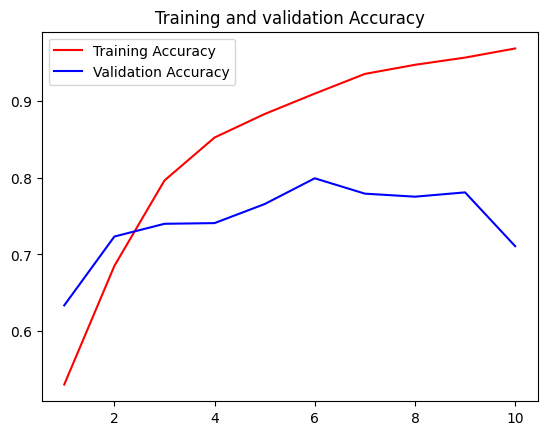

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.5011 - loss: 0.7141 - val_accuracy: 0.5116 - val_loss: 0.6926
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.5176 - loss: 0.6986 - val_accuracy: 0.5281 - val_loss: 0.6918
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.5075 - loss: 0.6962 - val_accuracy: 0.5268 - val_loss: 0.6915
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.5259 - loss: 0.6920 - val_accuracy: 0.5246 - val_loss: 0.6914
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.5210 - loss: 0.6920 - val_accuracy: 0.5098 - val_loss: 0.6919
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.5435 - loss: 0.6878 - val_accuracy: 0.5218 - val_loss: 0.6906
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.5513 - loss: 0.6886 - val_accuracy: 0.5386 - val_loss: 0.6896
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.5555 - loss: 0.6859 - v

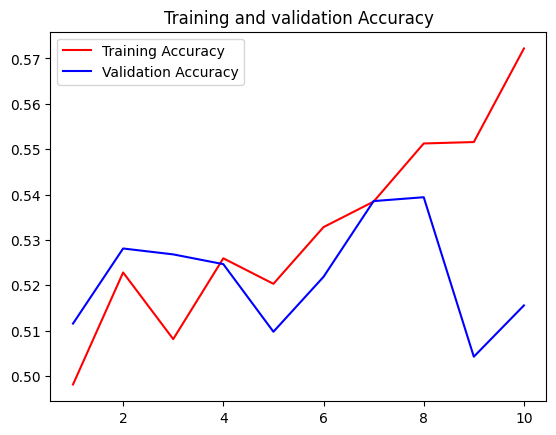

Training samples: 100
Embedding layer test accuracy: 0.797
Pretrained embeddings test accuracy: 0.540
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.5114 - loss: 0.6929 - val_accuracy: 0.6579 - val_loss: 0.6436
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.6729 - loss: 0.6079 - val_accuracy: 0.7666 - val_loss: 0.5092
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8068 - loss: 0.4548 - val_accuracy: 0.7940 - val_loss: 0.4514
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.8620 - loss: 0.3684 - val_accuracy: 0.7364 - val_loss: 0.6587
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8863 - loss: 0.3120 - val_accuracy: 0.7850 - val_loss: 0.5383
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.9100 - loss: 0.2509 - val_accuracy: 0.7099 - val_loss: 0.6772
Epoch 7/10
157/157 ━━━━━━━━━━━

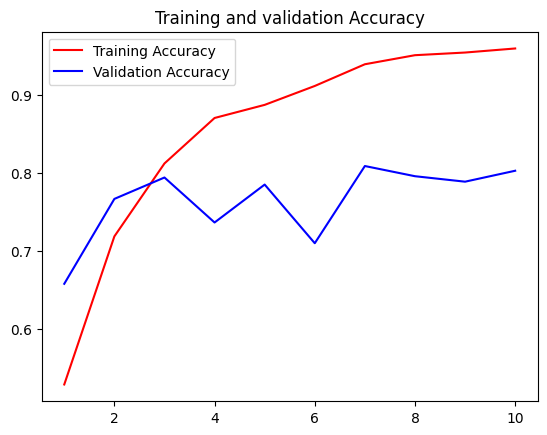

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.4986 - loss: 0.7202 - val_accuracy: 0.5253 - val_loss: 0.6916
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - accuracy: 0.5003 - loss: 0.6969 - val_accuracy: 0.5000 - val_loss: 0.6975
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - accuracy: 0.5142 - loss: 0.6958 - val_accuracy: 0.5000 - val_loss: 0.7217
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.5222 - loss: 0.6949 - val_accuracy: 0.5333 - val_loss: 0.6902
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - accuracy: 0.5347 - loss: 0.6887 - val_accuracy: 0.5045 - val_loss: 0.6950
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.5343 - loss: 0.6903 - val_accuracy: 0.5103 - val_loss: 0.6939
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.5391 - loss: 0.6860 - val_accuracy: 0.5466 - val_loss: 0.6865
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.5544 - loss: 0.6840 - v

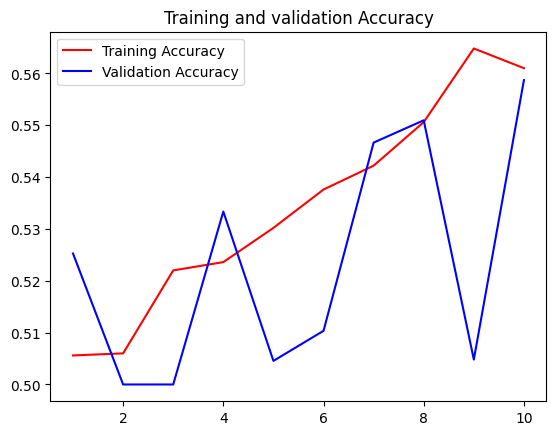

Training samples: 500
Embedding layer test accuracy: 0.793
Pretrained embeddings test accuracy: 0.556
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.5191 - loss: 0.6897 - val_accuracy: 0.5170 - val_loss: 0.7263
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.7227 - loss: 0.5666 - val_accuracy: 0.6834 - val_loss: 0.6944
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.8074 - loss: 0.4504 - val_accuracy: 0.7735 - val_loss: 0.4796
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.8726 - loss: 0.3331 - val_accuracy: 0.7999 - val_loss: 0.4377
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 56ms/step - accuracy: 0.9052 - loss: 0.2678 - val_accuracy: 0.7645 - val_loss: 0.6027
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9291 - loss: 0.2224 - val_accuracy: 0.7936 - val_loss: 0.5009
Epoch 7/10
157/157 ━━━━━━━━━━

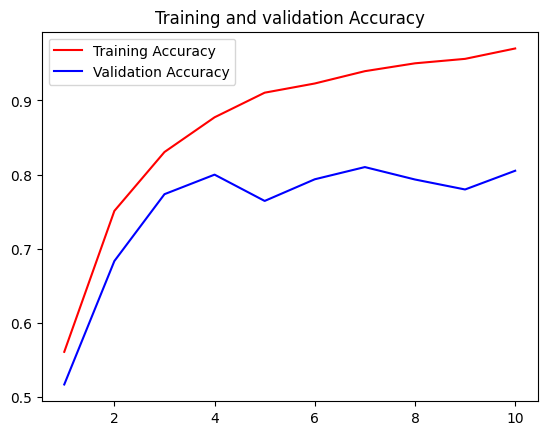

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.5099 - loss: 0.7110 - val_accuracy: 0.5141 - val_loss: 0.6924
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.5114 - loss: 0.6937 - val_accuracy: 0.5000 - val_loss: 0.6996
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.5129 - loss: 0.6940 - val_accuracy: 0.5102 - val_loss: 0.6925
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 48ms/step - accuracy: 0.5068 - loss: 0.6944 - val_accuracy: 0.5001 - val_loss: 0.6967
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.5285 - loss: 0.6903 - val_accuracy: 0.5339 - val_loss: 0.6876
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.5446 - loss: 0.6850 - val_accuracy: 0.5381 - val_loss: 0.6854
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.5505 - loss: 0.6847 - val_accuracy: 0.5802 - val_loss: 0.6780
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.5876 - loss: 0.6733 - val_

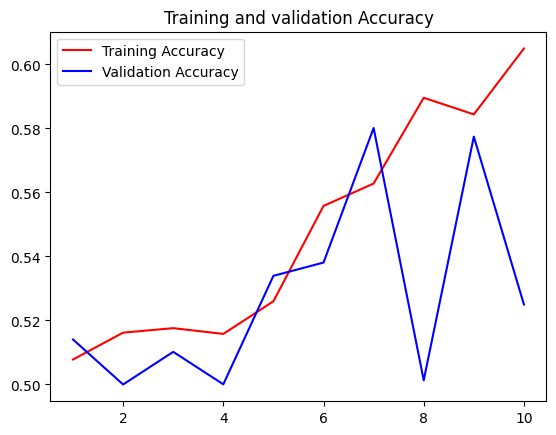

Training samples: 1000
Embedding layer test accuracy: 0.796
Pretrained embeddings test accuracy: 0.571
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.5214 - loss: 0.6904 - val_accuracy: 0.6719 - val_loss: 0.6069
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.7319 - loss: 0.5602 - val_accuracy: 0.7315 - val_loss: 0.5433
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8247 - loss: 0.4209 - val_accuracy: 0.7831 - val_loss: 0.4656
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8780 - loss: 0.3216 - val_accuracy: 0.7070 - val_loss: 0.6416
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.9044 - loss: 0.2679 - val_accuracy: 0.8091 - val_loss: 0.4536
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9253 - loss: 0.2230 - val_accuracy: 0.8046 - val_loss: 0.5205
Epoch 7/10
157/157 ━━━━━━━━━━━

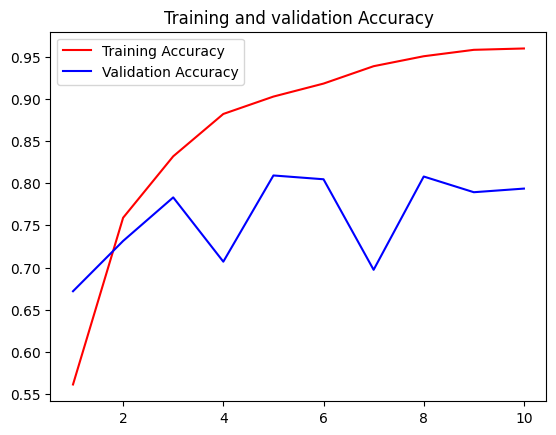

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.5096 - loss: 0.7088 - val_accuracy: 0.5153 - val_loss: 0.6924
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.5081 - loss: 0.6957 - val_accuracy: 0.5035 - val_loss: 0.6928
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 59ms/step - accuracy: 0.5210 - loss: 0.6912 - val_accuracy: 0.5293 - val_loss: 0.6908
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.5342 - loss: 0.6908 - val_accuracy: 0.5210 - val_loss: 0.6911
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 83ms/step - accuracy: 0.5271 - loss: 0.6908 - val_accuracy: 0.5153 - val_loss: 0.6912
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.5427 - loss: 0.6870 - val_accuracy: 0.5073 - val_loss: 0.6972
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.5495 - loss: 0.6845 - val_accuracy: 0.5466 - val_loss: 0.6870
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.5544 - loss: 0.6840 - val

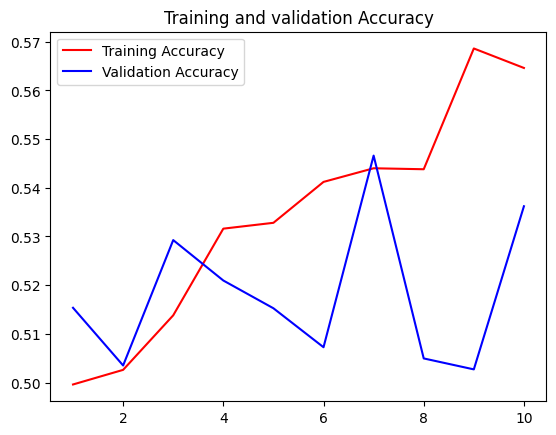

Training samples: 5000
Embedding layer test accuracy: 0.807
Pretrained embeddings test accuracy: 0.548
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.5154 - loss: 0.6919 - val_accuracy: 0.6548 - val_loss: 0.6303
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.6996 - loss: 0.5907 - val_accuracy: 0.7351 - val_loss: 0.5383
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8129 - loss: 0.4368 - val_accuracy: 0.8077 - val_loss: 0.4545
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.8558 - loss: 0.3653 - val_accuracy: 0.7907 - val_loss: 0.4519
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.8943 - loss: 0.2984 - val_accuracy: 0.7528 - val_loss: 0.6875
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.8984 - loss: 0.2691 - val_accuracy: 0.8134 - val_loss: 0.4716
Epoch 7/10
157/157 ━━━━━━━━━━

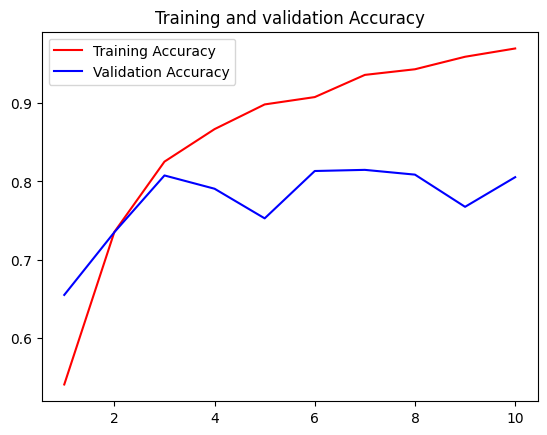

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.4949 - loss: 0.7150 - val_accuracy: 0.5011 - val_loss: 0.6943
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 86ms/step - accuracy: 0.5091 - loss: 0.6957 - val_accuracy: 0.5020 - val_loss: 0.6947
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.5094 - loss: 0.6943 - val_accuracy: 0.5018 - val_loss: 0.6944
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - accuracy: 0.5339 - loss: 0.6900 - val_accuracy: 0.5000 - val_loss: 0.7084
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.5352 - loss: 0.6921 - val_accuracy: 0.5207 - val_loss: 0.6913
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.5326 - loss: 0.6880 - val_accuracy: 0.5156 - val_loss: 0.6930
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.5301 - loss: 0.6884 - val_accuracy: 0.5373 - val_loss: 0.6887
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.5610 - loss: 0.6836 - va

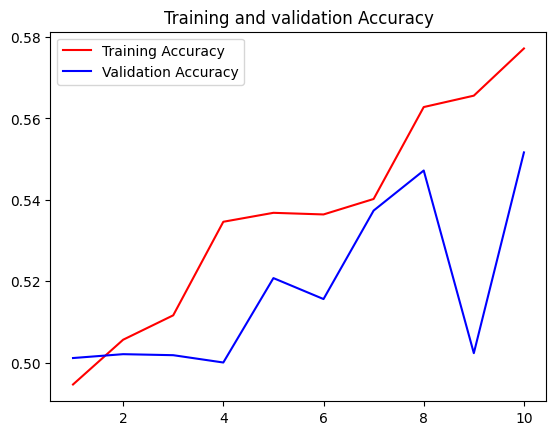

Training samples: 10000
Embedding layer test accuracy: 0.791
Pretrained embeddings test accuracy: 0.553
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.5034 - loss: 0.6929 - val_accuracy: 0.6270 - val_loss: 0.6540
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.6859 - loss: 0.6026 - val_accuracy: 0.7549 - val_loss: 0.5140
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8094 - loss: 0.4485 - val_accuracy: 0.7033 - val_loss: 0.6884
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.8667 - loss: 0.3474 - val_accuracy: 0.7701 - val_loss: 0.5177
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.8899 - loss: 0.2950 - val_accuracy: 0.7838 - val_loss: 0.4696
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.9282 - loss: 0.2248 - val_accuracy: 0.7982 - val_loss: 0.4640
Epoch 7/10
157/157 ━━━━━━━━━━

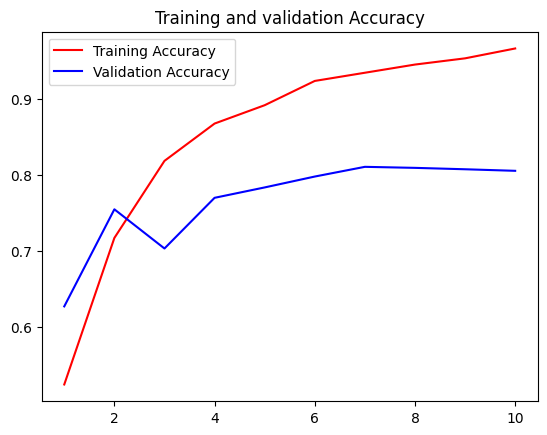

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.4970 - loss: 0.7189 - val_accuracy: 0.5016 - val_loss: 0.6938
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.4974 - loss: 0.6968 - val_accuracy: 0.5003 - val_loss: 0.6948
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.5159 - loss: 0.6939 - val_accuracy: 0.5000 - val_loss: 0.6998
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.5217 - loss: 0.6922 - val_accuracy: 0.5031 - val_loss: 0.6930
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.5315 - loss: 0.6889 - val_accuracy: 0.5013 - val_loss: 0.6999
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.5405 - loss: 0.6900 - val_accuracy: 0.5476 - val_loss: 0.6872
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.5459 - loss: 0.6849 - val_accuracy: 0.5145 - val_loss: 0.6937
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.5588 - loss: 0.6844 - val

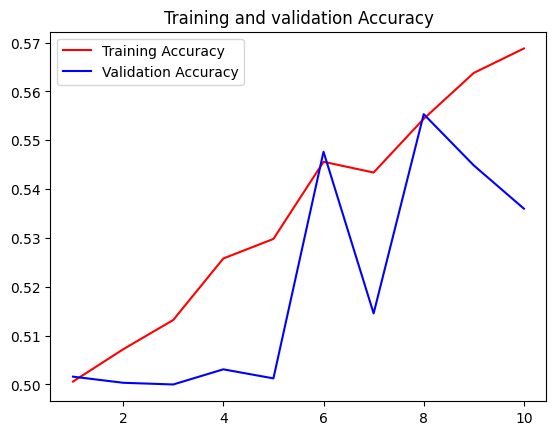

Training samples: 20000
Embedding layer test accuracy: 0.797
Pretrained embeddings test accuracy: 0.552
--------------------------------------------------


In [48]:
train_sample_sizes = [100, 500, 1000, 5000, 10000, 20000]
for train_size in train_sample_sizes:
    train_ds = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=b_size
    ).take(train_size)

    int_train_ds = train_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_val_ds = v_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_test_ds = te_ds.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )

    # Train and evaluate the model with the embedding layer
    embedding_layer = layers.Embedding(max_t, em_dim)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_model.keras",
                                        save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("embeddings_model.keras")
    embedding_layer_test_acc = model.evaluate(int_test_ds)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Train and evaluate the model with the pretrained word embeddings
    embedding_layer = layers.Embedding(
        max_t,
        em_dim,
        embeddings_initializer=keras.initializers.Constant(em_matrix),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("pretrained_embeddings_model.keras",
                                        save_best_only=True)
    ]
    history = model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("pretrained_embeddings_model.keras")
    pretrained_embeddings_test_acc = model.evaluate(int_test_ds)[1]

    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, val_loss, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Compare the performance and store the results
    print(f"Training samples: {train_size}")
    print(f"Embedding layer test accuracy: {embedding_layer_test_acc:.3f}")
    print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
    print("-" * 50)